## Text Mining by Word Representation

### 任务描述

本次实验需要针对一百万篇疫情相关论文进行文本挖掘。具体的，根据用户提供的问句进行内容检索，并以适当形式展示。

其中，使用聚类方法完成文献检索部分。问答仍然采用bio-bert。

### 实验流程

- 我主要复现了老师写在PPT中的这篇论文的工作：

<div align=center>
<img src="pic2\1.png" style="zoom:45%" />
</div>

论文来源：https://aclanthology.org/2020.nlpcovid19-acl.7.pdf

- 下图展示了本文的实验流程：

<div align=center>
<img src="pic2\2.png" style="zoom:20%" />
</div>

模型分为**在线**和**离线**两部分，离线阶段将原始文献根据引用关系构建**无向图**，并对其进行**ego-splitting** ，得到**有重叠聚类**结果。之后保留簇中文章数大于1000的文章作为**关键簇**，从每个关键簇中进行**随机采样**并将采样结果进行**biobert表示**，已代表各簇；将query同样利用biobert进行表示，计算其与各簇间的**平均相似性**，其中距离度量手段为**余弦相似度**，随机选择最相似簇中的文章以作为候选文章，并对其QA。

由于原论文没有开源，所以我从零复现了代码。首先介绍一下我对原始论文步骤的改动：
- 原论文使用了全部文献构建无向图，我这里只选用被引文献出版年份大于等于2020年的文献（这些文献不一定在metadata.csv中出现）。由于2020年前出版的文献数量上不及近三年文献，而且我认为使用全部文献会额外引入噪声，降低聚类效果，因此舍掉了那部分；
- 据我统计，在2020年及以后发表的文献中，仅有365篇互相引用。为了弥补这方面的缺失（我认为），论文使用Sen2Vec对题目进行嵌入，并将所有节点（节点代表文献）进行相似度计算，将超过阈值的两篇文献连接。但是我在复现过程中发现，一是Sen2Vec核心代码目前只支持Linux版本，二是最终有七十多万个节点，算法的复杂度太高我电脑处理不了，所以舍弃这一步；
- 作者对原始论文进行聚类后，对于输入的query分配到最相似簇中。然而，作者并没有描述这一过程的执行细节。首先，原图经ego-splitting后会产生数千个簇，而据我统计这些簇中文献个数也迥然不同。举例来讲，有些簇中文献数目高到上万，有些簇中文献数不及100。因此，我对原始簇进行筛选，只保留了簇内文献数大于等于1000的簇作为“关键簇”，最终共有137个关键簇；
- “关键簇”中文献数目也很多，将所有进行表示也不现实。为了加快运行时间，我对关键簇中文献进行随机采样，选出100篇进行表示，并计算与问句的平局相似性，其中距离度量手段为余弦相似度。最终，返回最相似的10个簇进行QA；

关于数据分析以及问答部分，和第一次作业完全相同，因此在这里不加赘述。

### 实验过程

#### 1. 导入第三方库

In [1]:
'''
@ author: 王中琦
@ date: 2022/5/4
'''
import pandas as pd
import json
import os
import sys
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from langdetect import detect
import torch
from transformers import  AutoTokenizer,AutoModelForQuestionAnswering
from warnings import filterwarnings
filterwarnings("ignore")

plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
%matplotlib inline

e:\anaconda\envs\biobert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2. 数据清洗

In [2]:
def search_focus(df):
    '''
    仅保留包含关键词语的论文
    '''
    dfa = df[df['abstract'].str.contains('covid')]
    dfb = df[df['abstract'].str.contains('-cov-2')]
    dfc = df[df['abstract'].str.contains('cov2')]
    dfd = df[df['abstract'].str.contains('ncov')]
    frames=[dfa,dfb,dfc,dfd]
    df = pd.concat(frames)
    df=df.drop_duplicates(subset='title', keep="first")
    return df

def year_focus(df):
    '''
    仅保留2020年及以后的论文
    '''
    dfa = df[df['publish_time'].str.contains('2020')]
    dfb = df[df['publish_time'].str.contains('2021')]
    dfc = df[df['publish_time'].str.contains('2022')]
    frames=[dfa,dfb,dfc]
    df = pd.concat(frames)
    df=df.drop_duplicates(subset='title', keep="first")
    return df 

# 装载数据
df=pd.read_csv('metadata.csv', usecols=['title','journal','abstract','authors','doi','publish_time','sha'])
print("原有数据：",df.shape)
# 填充缺省值
df=df.fillna('N/A')
# 数据去重
df = df.drop_duplicates(subset='title', keep="first")
# 将字符变小写
df["abstract"] = df["abstract"].str.lower()
df["title"] = df["title"].str.lower()
df = search_focus(df)
df = year_focus(df)
print("数据清洗后：",df.shape)

原有数据： (1015768, 7)
数据清洗后： (352435, 7)


#### 3. 聚类

##### 3.1 paper->id

In [11]:
def paper2id():
    '''
    这段代码只用运行一次就可以了,将所有论文转换为id序列
    '''
    folder_path = "pdf_json"
    file_names = os.listdir(folder_path)
    all_paper = {}
    num=0
    for file_name in file_names:
        num+=1
        with open('pdf_json/'+file_name) as json_file:
            file = json.load(json_file)
            all_bib = file['bib_entries']
            for key, value in all_bib.items():
                try: # 异常解决年份为None情况
                    if all_bib[key]["year"]>=2020:
                        if all_bib[key]["title"] not in all_paper:
                            all_paper[all_bib[key]["title"]] = len(all_paper)
                except:
                    pass

        sys.stdout.write(
                "\r[Done %d/%d]"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
                % (num, len(file_names))
            )
        
    with open("paper2id.json", "w", encoding='utf8') as f:
        f.write(json.dumps(all_paper, ensure_ascii=False, indent=4, separators=(',', ':')))

# paper2id()


[Done 377057/377057]

##### 3.2 id->paper

In [12]:
def id2paper():
    '''
    这段代码只用运行一次就可以了,将id序列转换为所有论文
    '''
    with open("paper2id.json",'r', encoding='utf8') as f:
        paper_to_id = json.load(f)

    id2paper = {}
    num=0
    for key,value in paper_to_id.items():
        id2paper[str(paper_to_id[key])] = key
        num+=1

        sys.stdout.write(
            "\r[Done %d/%d]"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
            % (num, len(paper_to_id))
        )

    with open("id2paper.json", "w", encoding='utf8') as f:
        f.write(json.dumps(id2paper, ensure_ascii=False, indent=4, separators=(',', ':')))

# id2paper()

##### 3.3 将聚类结果的类命名

具体的ego-splitting聚类代码来自：https://github.com/benedekrozemberczki/EgoSplitting

我将我构建的无向图（paper_edges.csv）变成该模型适应的输入格式，得到paper_cluster_memberships.json（聚类结果）

为了更好地进行筛选，这里选择簇中文献超出1000篇的文献簇，作为关键簇

In [17]:
def position():
    '''
    这段代码只用运行一次就可以了, 给类别打标签, 返回同一类的id
    paper_cluster_memberships.json 这个是ego-图割的代码跑出来的结果
    '''
    with open("paper_cluster_memberships.json",'r', encoding='utf8') as f:
        new_graph = json.load(f)

    G = nx.Graph()
    nodes = []
    edge = []
    num=0
    for key,value in new_graph.items():
        num+=1
        nodes.append(eval(key))
        for i in range(len(new_graph[key])):
            edge.append((eval(key),new_graph[key][i]))

        if num%50000 == 0:
            # print(nodes,edge)
            print("\r[Done %d/%d]"% (num, len(new_graph)))
            # break


    G.add_nodes_from(nodes)
    G.add_edges_from(edge)

    # compute the best partition
    partition = community_louvain.best_partition(G)

    results = list(partition.values())

    labels = list(set(partition.values()))

    print("共有{}类".format(len(labels)))

    # --------------------- 如果需要进行筛选 -----------------------
    topic = []
    for i in range(len(labels)):
        label = labels[i]
        num = results.count(label)
        print(num)
        
        if num >= 1000:
            topic.append(label)
    # --------------------- 如果需要进行筛选 -----------------------
    print(len(topic))
    
    position = {}

    for i in range(len(topic)-1):
        label = topic[i]
        position_label = []
        for j in range(len(results)):
            if results[j] == label:
                position_label.append(j)
        position[str(label)] = position_label

        if i%50 == 0:
            print("马上就好了！")
    
    print("Done!")

    with open("position.json", "w", encoding='utf8') as f:
        f.write(json.dumps(position, ensure_ascii=False, indent=3, separators=(',', ':')))

# position()

[Done 50000/791881]
[Done 100000/791881]
[Done 150000/791881]
[Done 200000/791881]
[Done 250000/791881]
[Done 300000/791881]
[Done 350000/791881]
[Done 400000/791881]
[Done 450000/791881]
[Done 500000/791881]
[Done 550000/791881]
[Done 600000/791881]
[Done 650000/791881]
[Done 700000/791881]
[Done 750000/791881]
共有150类
9265
13263
86663
2800
64149
11275
11985
8223
8322
7669
9817
16291
13475
17841
18612
7136
22212
11880
15589
13555
16587
16482
13568
12792
13403
14189
17303
19587
7376
12351
15970
3968
14363
5169
14732
17071
17400
10855
10368
20632
15572
4965
8809
4522
6575
3468
8180
8897
4697
142466
1690
12859
6341
104066
10390
4972
5836
6627
10498
11322
14814
3770
14151
11837
16055
10974
4215
7740
7607
6502
6431
9708
14358
4192
9194
9679
6458
9588
7601
6239
6005
5661
4943
16506
6599
6511
9030
10995
13255
5119
13659
4106
4084
12361
11581
16980
6467
5902
6723
3426
3786
6348
13824
25674
5099
8090
2667
7735
10599
4544
9416
7476
10693
9980
7329
5782
6638
3199
3498
2422
4989
5452
5988
18231
73

由于聚类结果太庞大了，这里仅展示原聚类结果千分之一的图，其中的粗黑点就是一个大的聚类簇。

[Done 50/791881]
聚类簇示例如下：


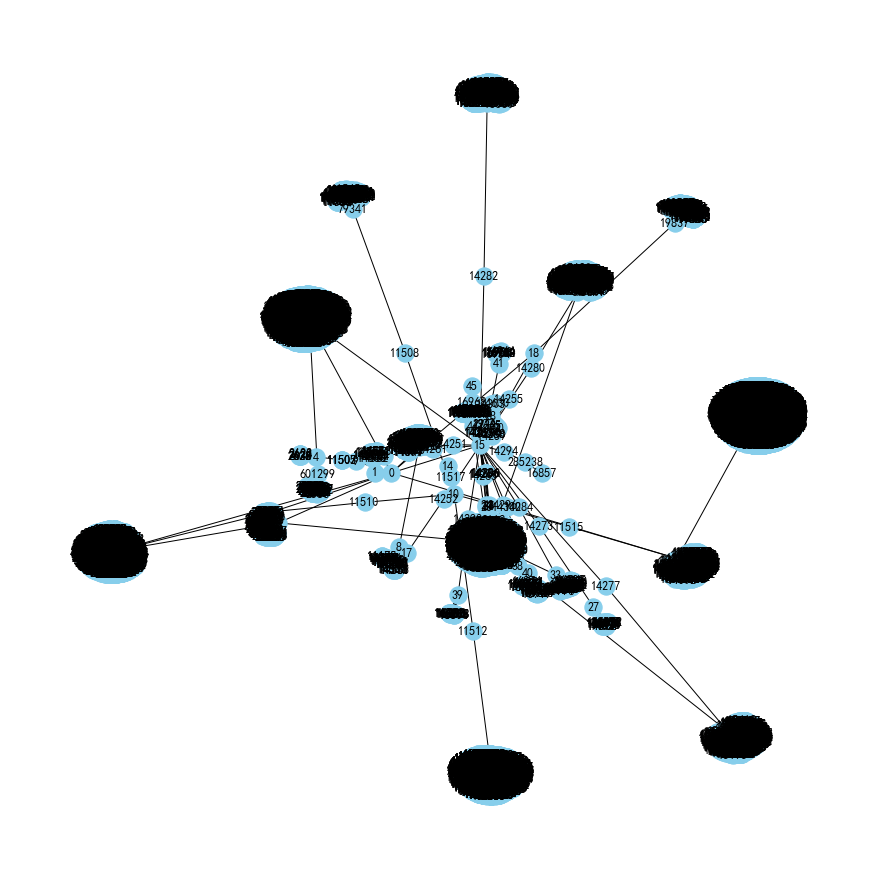

In [18]:
with open("paper_cluster_memberships.json",'r', encoding='utf8') as f:
    new_graph = json.load(f)

G = nx.Graph()
nodes = []
edge = []
num=0
for key,value in new_graph.items():
    num+=1
    nodes.append(key)
    for i in range(len(new_graph[key])):
        if key == str(new_graph[key][i]):
            continue
        edge.append((key,str(new_graph[key][i])))

    if num%50 == 0:
        # print(nodes,edge)
        print("\r[Done %d/%d]"% (num, len(new_graph)))
        break


G.add_nodes_from(nodes)
G.add_edges_from(edge)
plt.figure(figsize=(12,12))


pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
print("聚类簇示例如下：")
plt.show()


#### 4. 提问并获取所有相关文章

##### 4.1 获取查询语句

In [19]:
# 查询语句
Q = 'What do we know about risk factors?'

##### 4.2 计算每个簇的平均相似度

对于每个关键簇，随机采样簇中100篇文章，计算与问题的平均相似度，作为该簇与问句的相似性

In [26]:
from biobert_embedding.embedding import BiobertEmbedding
import random
import torch

biobert = BiobertEmbedding()

with open("id2paper.json",'r', encoding='utf8') as f:
    id_to_paper = json.load(f)

with open("position.json",'r', encoding='utf8') as f:
    position = json.load(f)

query_vector = biobert.sentence_vector(Q)
label_score = {}

num=0
for key, value in position.items():
    num+=1
    all = 0
    current_papers = position[key]
    # try:
    choice_papers = random.sample(current_papers, 10)
    for paper in choice_papers:
        title = id_to_paper[str(paper)]
        result = biobert.sentence_vector(title)
        similarity = torch.cosine_similarity(query_vector, result, dim=0)
        all += similarity
    average_socre = all/len(choice_papers)
    label_score[key]=average_socre.item()
    # except:
    #     pass

    if num%10==0:
        print("done[{}|{}]".format(num,len(position)))

label_score = pd.DataFrame(list(label_score.items()))
label_score.sort_values(by=1 , inplace=True, ascending=False)
label_score.head(5)

# '''
# 输出长这样:

#      0         1
# 77  79  0.831887
# 28  28  0.831751
# 54  55  0.831047
# 80  82  0.827677
# 34  34  0.827628
# ..  ..       ...
# 21  21  0.802501
# 68  70  0.801273
# 2    2  0.799454
# 71  73  0.796601
# 24  24  0.779584
#     |-> 这个 | 列是聚类的id
#              |-> 这个列表示文献和问句间的相似性，越高越好
# '''


1
done[10|149]
done[20|149]
done[30|149]
done[40|149]
done[50|149]
done[60|149]
done[70|149]
done[80|149]
done[90|149]
done[100|149]
done[110|149]
done[120|149]
done[130|149]
done[140|149]


,0,1
100,100,0.810729
0,0,0.807852
108,108,0.807573
83,83,0.806804
43,43,0.806171


选取其中相似性最大的30个簇，对这些簇中再采样100篇，即总共3000篇为与问题相关候选文献。

In [53]:
num = 0
# 将id转换为文章title
related_papers = []
for key, value in position.items():
    if num==30:
        break
    num+=1
    all = 0
    current_papers = position[key]
    try:
        choice_papers = random.sample(current_papers, 100)
        for paper in choice_papers:
            title = id_to_paper[str(paper)]
            related_papers.append(title.lower())
    except:
        pass

print(related_papers[:10])
print(len(related_papers))

['a rapid mobilization of "virtual" primary care services in response to covid-19 at veterans health administration', 'novel coronavirus and hospital infection prevention: preparing for the impromptu speech', 'a systematic narrative review of comprehensive preparedness strategies of healthcare resources for a large resurgence of covid-19 nationally, with local or regional epidemics: present era and beyond', 'iron oxide nanoparticle core-shell magnetic microspheres: applications toward targeted drug delivery', 'kordzadeh-kermani e, khalili h, karimzadeh i. pathogenesis, clinical manifestations and 387 complications of coronavirus disease 2019 (covid-19)', 'grand challenges in pharmaceutical research series: ridding the cold chain for biologics', 'can carbon quantum dots (cqds) or boron compounds be an ultimate solution for covid-19 therapy? iran', 'fetal diagnosis and therapy during the covid-19 pandemic: guidance on behalf of the international fetal medicine and surgery society', 'comp

以下和实验一的设置完全相同，故不再进行赘述

In [54]:
def format_body(body_text):
    '''获得文章的全部文本'''
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    
    for section, text in texts:
        texts_di[section] += text

    body = ""

    # 需要的段落
    need = ["ABSTRACT","CONCLUSION","METHOD","INFECT","EFFECT","FACTOR","ANALY","DIFFER","RESULT"]

    for section, text in texts_di.items():
        
        flag = 0
        for ne in need:
            if section.upper().find(ne)!=-1: # 将文献小节题目大写
                flag = 1
                break
        if flag:
            body += section # ABSTRACT,BACKGROUND,CASE,CONCLUSION,DISSCUSION, etc.
            body += " "
            body += text
            body += "\n\n"
        
    
    return body

Candidate_articles = []


for index, row in df.iterrows():
    if row['title'] in related_papers: 
        if 'N/A' not in row['sha'] and os.path.exists('pdf_json/'+row['sha']+'.json')==True:
            with open('pdf_json/'+row['sha']+'.json') as json_file:
                data = json.load(json_file)
                body=format_body(data['body_text'])
                try:
                    if detect(body) != 'en': # 只保留英文文本
                        continue
                    # print(body)
                    Candidate_articles.append([row['sha'],row['abstract'],body])
                except:
                    pass
        # 否则将text赋值为abstract
        else:
            try:
                if detect(body) != 'en': # 只保留英文文本
                    continue
                # print(body)
                Candidate_articles.append([row['sha'],row['abstract'],row['abstract']])
            except:
                pass 

Candidate_articles = pd.DataFrame(Candidate_articles,columns = ['sha','abstract','text'])
print("全文预处理完毕")
Candidate_articles.head(5)

全文预处理完毕


,sha,abstract,text
0,f786bcbbd454d1e47d5ad51e08ed95a5b87ad01c,"in this study, we review the initial impacts o...",Results The simplest way to summarize the over...
1,N/A,twitter has considerable capacity for health e...,twitter has considerable capacity for health e...
2,N/A,background: the covid-19 pandemic has certainl...,background: the covid-19 pandemic has certainl...
3,N/A,convalescent blood product therapy has been in...,convalescent blood product therapy has been in...
4,N/A,"background: during the covid-19 pandemic, sout...","background: during the covid-19 pandemic, sout..."


In [56]:
# 使用文献全部内容
recommendations = []
for index, row in Candidate_articles.iterrows():
        recommendations.append(row['text'])

recommendations[0]

'Results The simplest way to summarize the overall impact of COVID-19 on the labour market is to examine the impact on aggregate weekly hours. In Figure 1 , we present aggregate weekly hours of individuals aged 20-64 years for each month since January 1976. 3 We can see large reductions in weekly hours in previous recessions (1981-1982, 1990-1992, and 2008-2009 ). However, the magnitude of losses in previous recessions is dwarfed by the losses in 2020. Comparing February and April 2020 directly (see Table 1 ), aggregate hours dropped 29 percent between February and April 2020. In Table 1 , we also provide estimates that adjust this loss in hours for normal February-April changes based on 2018 aggregate hours. Once adjusted, we fi nd the overall COVID-19 impact was a 32 percent decline in aggregate hours.The loss in work hours is made up of two components: signifi cant losses of jobs on the extensive margin and reductions in hours worked on the intensive margin. (In Table 2 , we present

In [57]:
len(recommendations)

433

#### 5. 问答

网址：https://huggingface.co/ktrapeznikov/biobert_v1.1_pubmed_squad_v2

以下和第一个实验的问答的代码相同，即使用Bio-BERT完成问答

In [58]:
tokenizer = AutoTokenizer.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

model = AutoModelForQuestionAnswering.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

In [59]:
def getanswers(question):
    '''
    获得答案和相关度
    '''
    questions= []
    contexts= []
    for bigcontext in recommendations:
        bigcontext = bigcontext.split(" ")
        for i in range(int(len(bigcontext)/60)):
          contexts.append(" ".join(bigcontext[i*60:60*(i+1)]))
          questions.append(question) # 这里问题不需要做去停词、标点等处理比较好
    # num=0
    answers = []
    for question, context in zip(questions,contexts):
      result = ask(question,context)
      if len(result[0].split(" ")) < 10 or '[SEP]' in result[0].split(" "): # 回答短于10个词的不要,有本身问句在回答中的不要
        continue
      # num+=1
      answers.append([result[0],result[-2].item()])
      # if num==10:
      #   break

    return answers

In [60]:
def ask(question,context):
    input_ids = tokenizer.encode(question, context)
    sep_index = input_ids.index(tokenizer.sep_token_id)

    num_seg_a = sep_index + 1

    num_seg_b = len(input_ids) - num_seg_a
    # 其中0代表问题，1代表文本
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    assert len(segment_ids) == len(input_ids)
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    # tokens, for example: ['[CLS]', 'old', 'person', 'risk', '[SEP]', 'age','[SEP]']

    outputs = model(input_ids= torch.tensor([input_ids]),token_type_ids=torch.tensor([segment_ids]))

    answer_end = 0
    answer_start = torch.argmax(outputs.start_logits)
    answer_ends = torch.argsort(outputs.end_logits).numpy()[::-1]
    for i in answer_ends[0]:
        if answer_start<= i:
            answer_end= i

    answer = ' '.join(tokens[answer_start:answer_end+1])
        
    answer = answer.replace(" ##","").replace("[CLS] ","")

    pack = [answer,answer_start,answer_end,torch.max(outputs.start_logits),outputs.end_logits[0][answer_end],(torch.max(outputs.start_logits)+outputs.end_logits[0][answer_end]),context]
    return pack

In [61]:
%%time
answers = getanswers(Q)

Wall time: 6min 19s


根据回答置信度进行排序

In [62]:
answers = pd.DataFrame(answers,columns = ['回答','置信度'])
answers.sort_values(by="置信度" , inplace=True, ascending=False)
answers.head(5)

,回答,置信度
23,our understanding of the association of corona...,8.675137
12,"sex , onset month , age group , city of residence",8.020144
32,there has not been evidence suggesting the lin...,7.398934
20,"D - dimer , interleukin ( IL ) - 6 and cardiac...",7.045435
27,other groups at increased risk because of unde...,7.043673


In [63]:
print("问题为：",Q)
num = 0 
for index, row in answers.iterrows():
    num+=1
    print("第{}条回答为：{}".format(num,row['回答']))
    
    if num==20:
        break

问题为： What do we know about risk factors?
第1条回答为：our understanding of the association of coronavirus disease 19 ( covid - 19 ) and preterm or early term birth among racially and ethnically diverse populations and those with chronic medical conditions is limited
第2条回答为：sex , onset month , age group , city of residence
第3条回答为：there has not been evidence suggesting the link between covid - 19 and asthma exacerbation
第4条回答为：D - dimer , interleukin ( IL ) - 6 and cardiac troponin I ( cTnI ) were excluded from the analysis because they were not routinely tested in the cohorts
第5条回答为：other groups at increased risk because of underlying medical conditions or morbid obesity
第6条回答为：to the best of our knowledge , the association between severe covid - 19 and dermatologic comorbidities has not been reported
第7条回答为：when some patients ignore their mild symptoms at the beginning or a potential carrier cannot get tested immediately
第8条回答为：population growth and seasonality will generally drive some part

In [64]:
num = 0 
with open("anwser_clustering.txt","a") as f:
    for index, row in answers.iterrows():
        f.write(row['回答']+"\n")
        num+=1
        if num==10:
            break
print("回答已保存至anwser_clustering.txt文件。")

回答已保存至anwser_clustering.txt文件。


#### 6.总结

在本文中，我使用了聚类的方法完成文献的问答模型。具体的，我复现了"Information Retrieval and Extraction on COVID-19 Clinical Articles Using Graph Community Detection and Bio-BERT Embeddings"，其中聚类方式为ego-splitting.